In [118]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller # used to check stationarity
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # ACF and PACF Plots
from sklearn.metrics import mean_squared_error

In [119]:
df=pd.read_csv('BTC-USD.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2755 entries, 2014-09-17 to 2022-04-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2755 non-null   float64
 1   High       2755 non-null   float64
 2   Low        2755 non-null   float64
 3   Close      2755 non-null   float64
 4   Adj Close  2755 non-null   float64
 5   Volume     2755 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 150.7 KB


<Axes: xlabel='Date'>

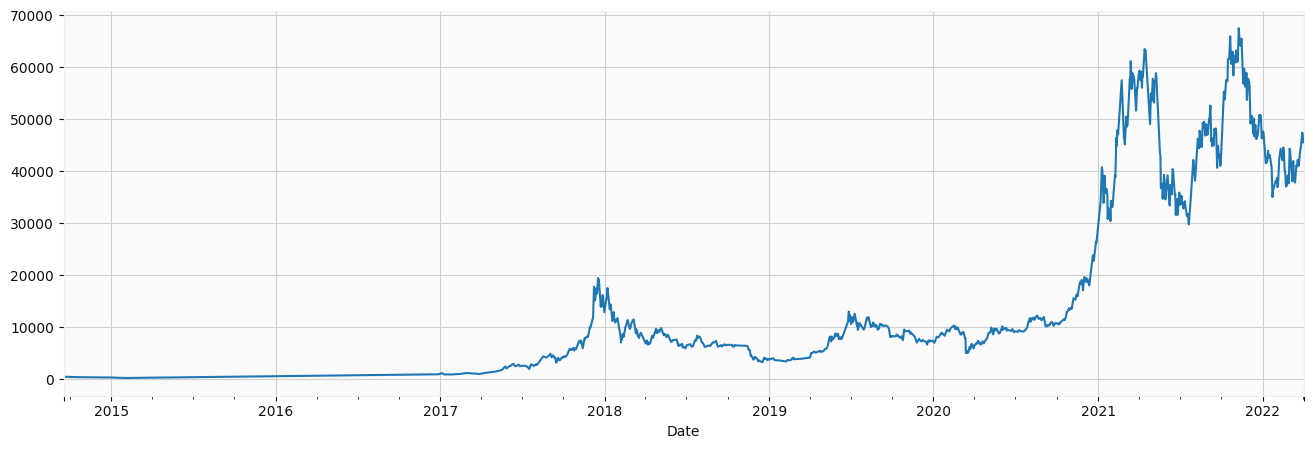

In [121]:
df['Open'].plot(figsize=(16,5)) #line plot of Open price 

<Axes: xlabel='Date'>

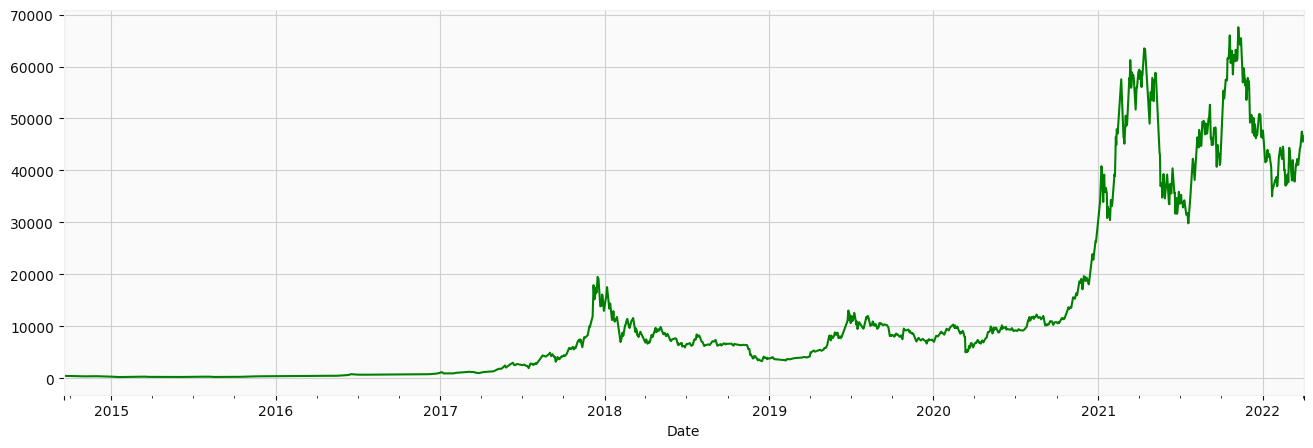

In [122]:
df['Close'].plot(figsize=(16,5), color = 'g') # line plot of Closed price

<Axes: xlabel='Date'>

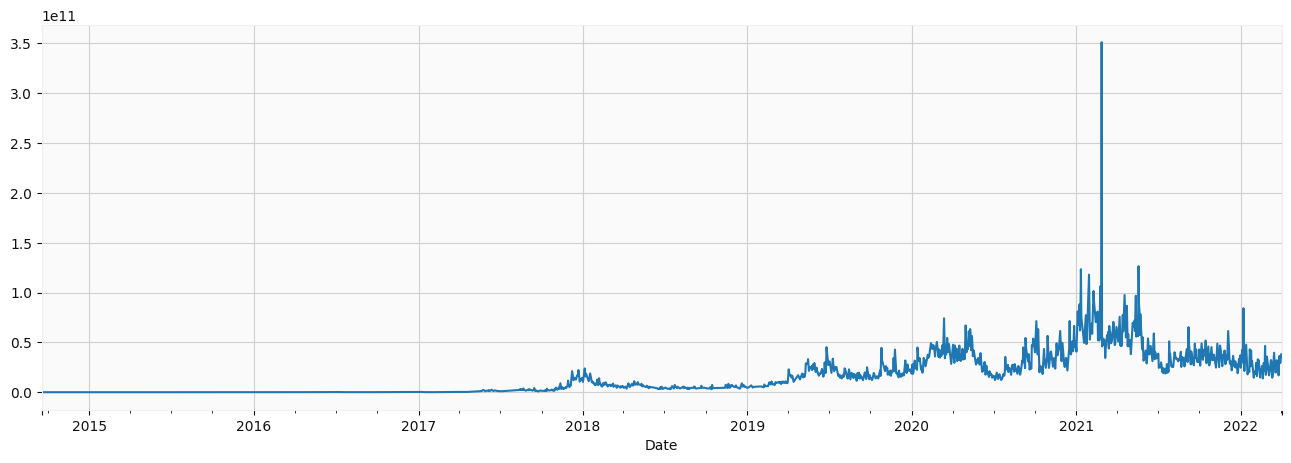

In [123]:
df['Volume'].plot(figsize=(16,5)) # line plot of volume 

<Axes: ylabel='Frequency'>

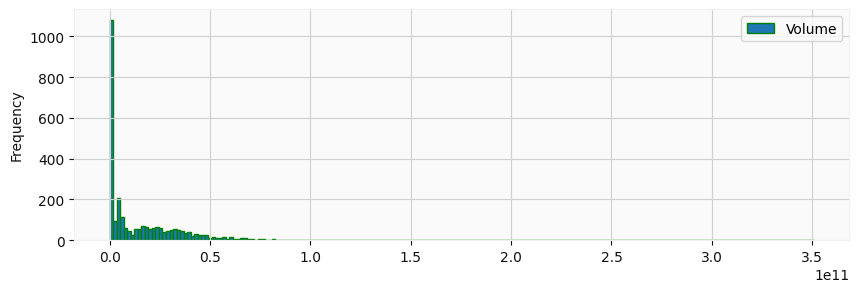

In [124]:
# histogram 
df.plot.hist(y='Volume', figsize=(10,3),bins=200,edgecolor='g')

In [125]:
#installing MPLfinance library for candle plots
# !pip install mplfinance 

In [126]:
import mplfinance as mpf

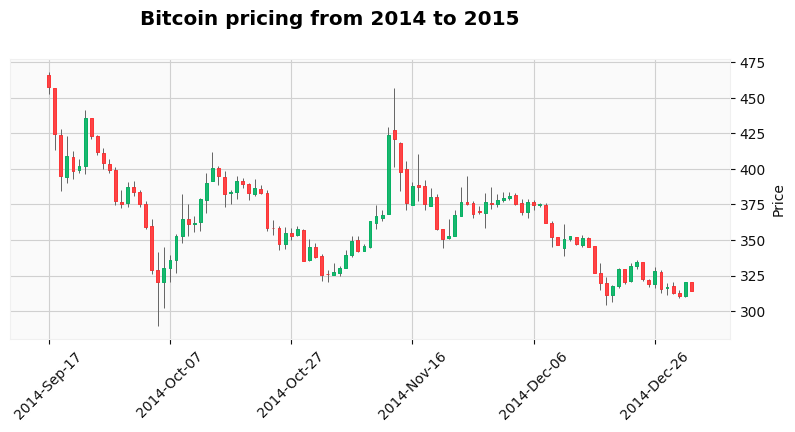

In [127]:
# Candle plot of closed price from 2014 to 2015
mpf.plot(df['2014-09-17' : '2015-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2014 to 2015', figsize=(10,4))

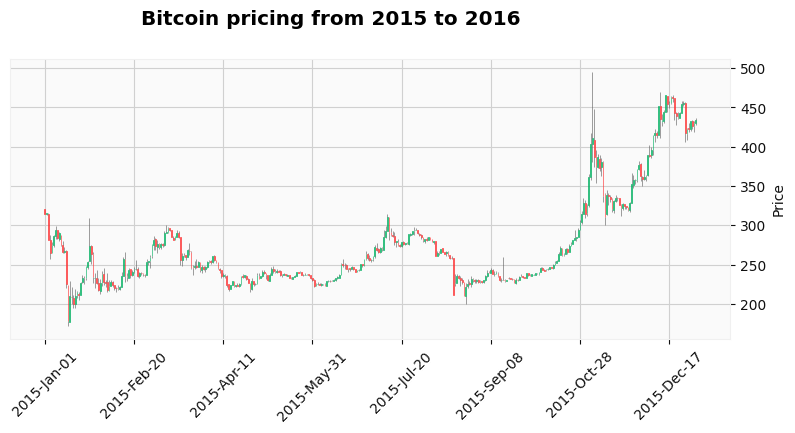

In [128]:
# Candle plot of closed price from 2015 to 2016
mpf.plot(df['2015-01-01' : '2016-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2015 to 2016', figsize=(10,4))

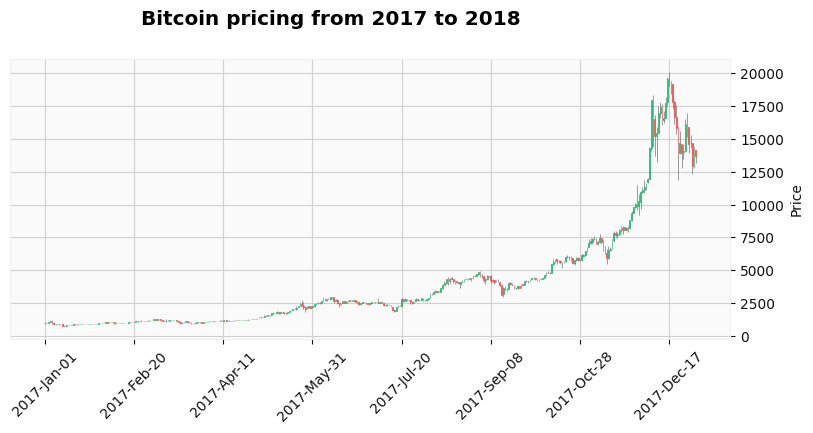

In [129]:
# Candle plot of closed price from 2017 to 2018
mpf.plot(df['2017-01-01' : '2018-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2017 to 2018', figsize=(10,4))

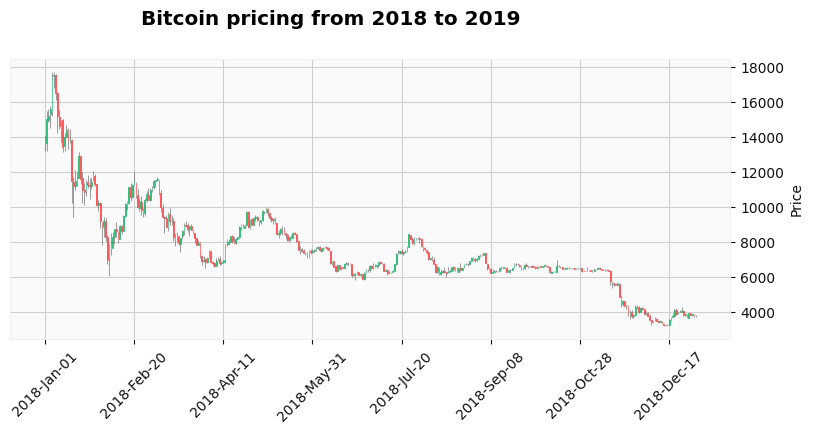

In [130]:
# Candle plot of closed price from 2018 to 2019
mpf.plot(df['2018-01-01' : '2019-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2018 to 2019', figsize=(10,4))

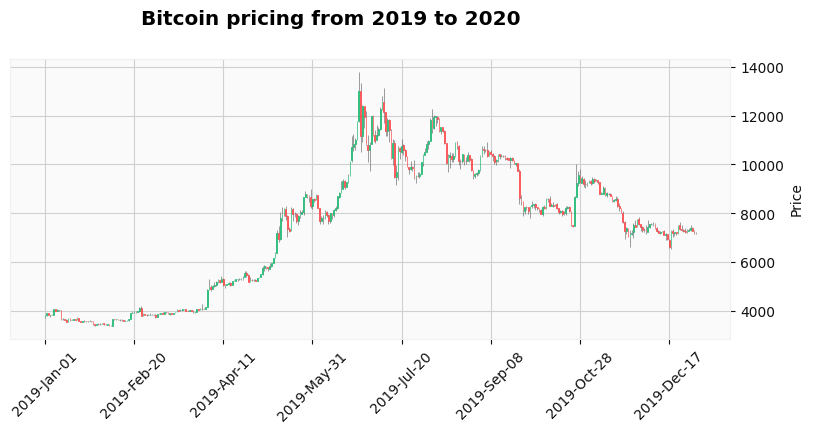

In [131]:
# Candle plot of closed price from 2019 to 2020
mpf.plot(df['2019-01-01' : '2020-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2019 to 2020', figsize=(10,4)) 

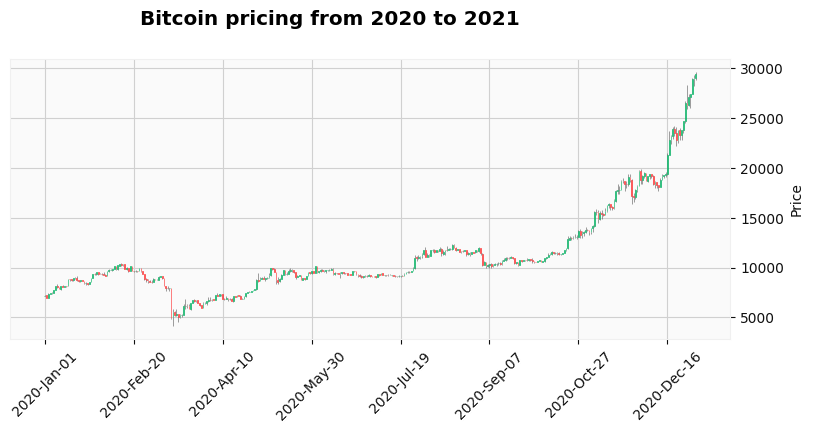

In [132]:
# Candle plot of closed price from 2020 to 2021
mpf.plot(df['2020-01-01' : '2021-01-01'], type='candle', style='yahoo', title='Bitcoin pricing from 2020 to 2021', figsize=(10,4)) 

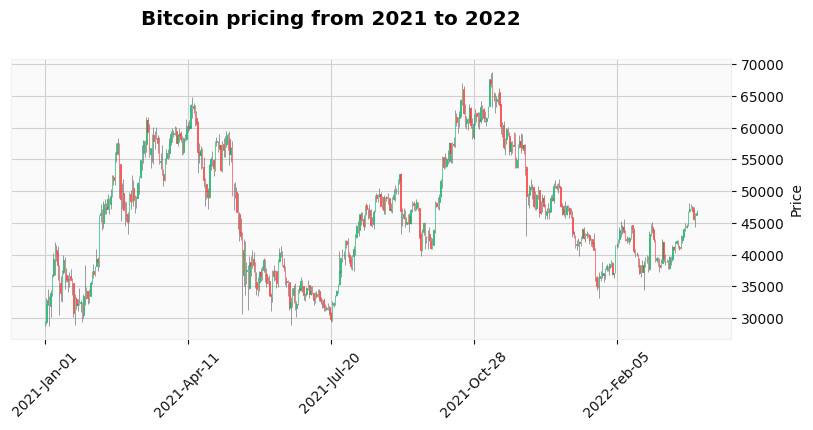

In [133]:
# Candle plot of closed price from 2021 to 2022
mpf.plot(df['2021-01-01' : '2022-04-02 '], type='candle', style='yahoo', title='Bitcoin pricing from 2021 to 2022', figsize=(10,4)) 

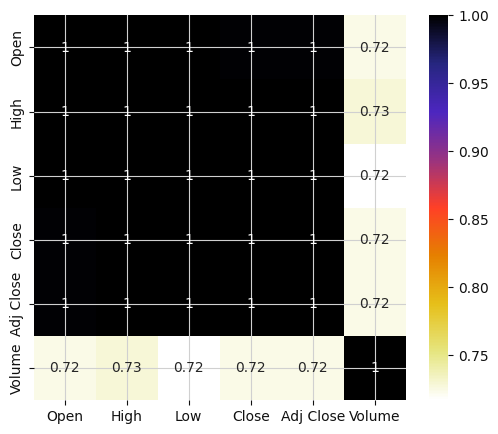

In [134]:
#corrilation between different features
plt.figure(figsize=(6,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

High Correlation Between Price Features: Open, High, Low, Close, and Adj Close show strong positive correlations.
These features are interdependent, as they all describe aspects of daily price movements.

Volume Has Lower Correlation with Prices: While trading volume is somewhat related to price, it is not a major driver of price changes.

Primary Variable for Analysis: 'Close' can be chosen as the primary variable for analysis and forecasting.

Feature Selection for Models: Dimensionality reduction or selecting key features (Close & Volume) can improve model efficiency.

Insights for Trading: Volume could be used as an auxiliary feature to identify patterns or anomalies but might not directly impact pricing trends.

In [135]:
#Adfuller test to check stationarity
A = df["Close"].values
result = adfuller(A)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho(null hyphothesis) - Time Series is Stationary")
else:
    print ("Failed to Reject Ho(null hyphothesis) - Time Series is Non-Stationary")

ADF Statistic: -0.842730
p-value: 0.806247
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject Ho(null hyphothesis) - Time Series is Non-Stationary


**ACF and PACF plots**

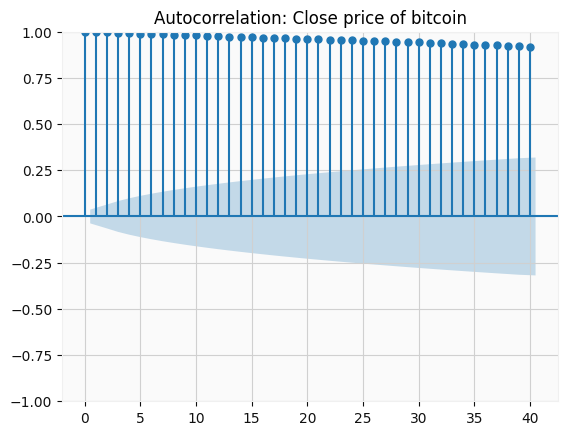

In [136]:
# ACF: Autocorrelation function
# Shows the correlation between a time series and its lags, which helps identify how past values influence current values. 

title = 'Autocorrelation: Close price of bitcoin'
lags = 40
plot_acf(df['Close'],title=title,lags=lags);

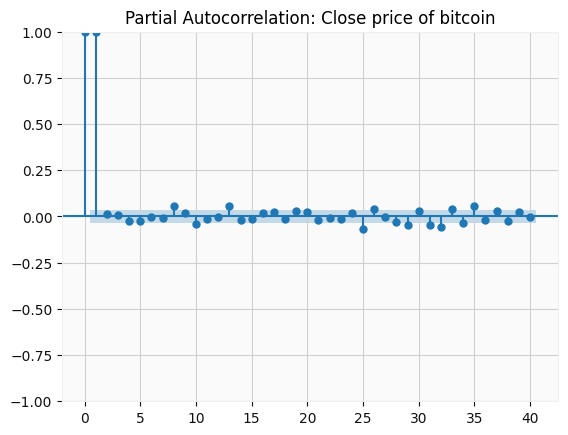

In [137]:
# PACF: Partial Autocorrelation function
# It accounts for the values of the intervals between the data points

title='Partial Autocorrelation: Close price of bitcoin'
lags=40
plot_pacf(df['Close'],title=title,lags=lags);

**the plots shows that we can use ARIMA order 1**

In [138]:
# 'Close' column for analysis
time_series = df['Close']

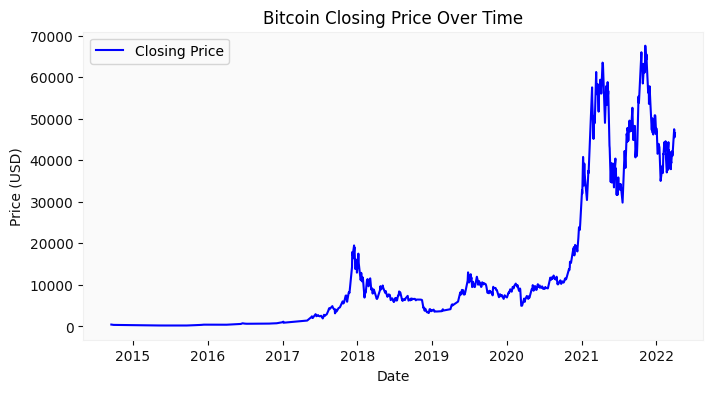

In [139]:
# 1. Visualizing the time series in one frame
plt.figure(figsize=(8,4))
plt.plot(time_series, label='Closing Price', color='blue')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [140]:
# 2. Making the series stationary if needed
time_series_diff = time_series.diff().dropna()
check_stationarity(time_series_diff)

ADF Statistic: -8.644318636918127
p-value: 5.3213633638461567e-14
Reject Ho(null hyphothesis) - Time Series is Stationary


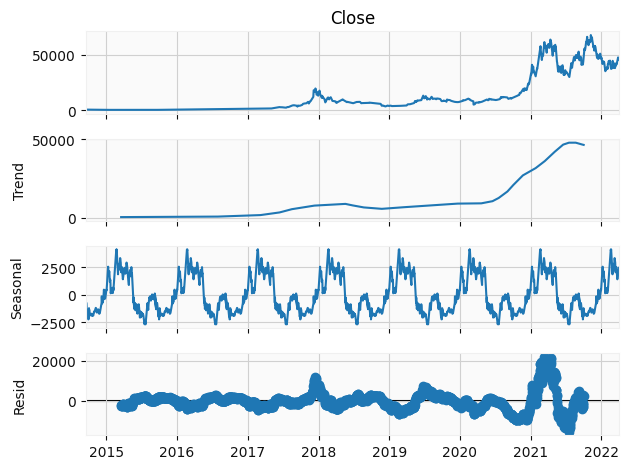

In [141]:
# 3. Decomposition of time series
decomposition = seasonal_decompose(time_series, model='additive', period=365)
decomposition.plot()
plt.show()

In [142]:
# 4. Split data into train and test sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

In [143]:
# 5. Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # tuning the order: (p, d, q) based on ACF/PACF
model_fit = model.fit()
print(model_fit.summary())

c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2204
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15579.334
Date:                Mon, 30 Dec 2024   AIC                          31164.667
Time:                        00:16:11   BIC                          31181.760
Sample:                    09-17-2014   HQIC                         31170.913
                         - 09-28-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0037      0.571     -0.007      0.995      -1.123       1.116
ma.L1          0.0178      0.572      0.031      0.975      -1.103       1.138
sigma2      8.144e+04    677.271    120.253      0.0

In [144]:
# 6. Fit SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [145]:
# 7. Forecast
forecast = model_fit.forecast(steps=len(test))
test.index = forecast.index

In [146]:
# 8. Evaluate the model
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse}")

RMSE: 32227.585500920915


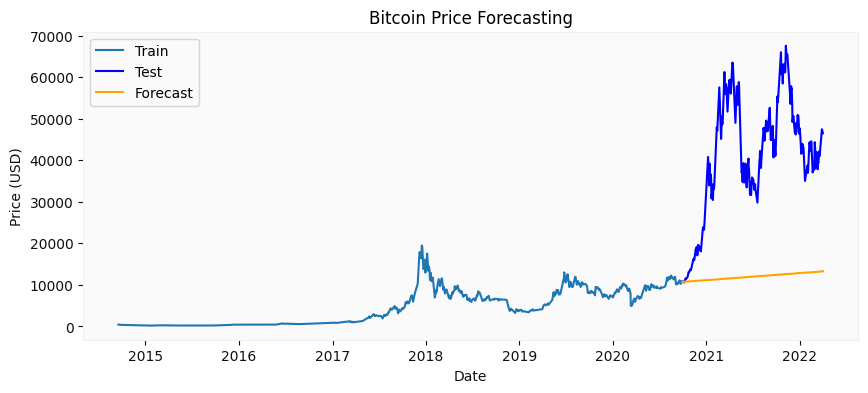

In [147]:
# 9. Plot the results
plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Forecast', color='orange')
plt.title('Bitcoin Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

**Actionable Insights: The code performs all essential steps from visualization to forecasting while keeping the process streamlined.**

**SARIMA Model: Provides robust handling of seasonality and trends for forecasting.**

**Evaluation Metric: RMSE ensures the forecast's accuracy is quantified.**